<font size="3">KINGDOM OF SAUDI ARABIA<br>
Ministry of Higher Education<br>                                  
Al-Imam Mohammad University<br>
College of Computer & Information Sciences<br><br>
    
 
**Deep Learning (CS464), Winter 22-23 - Second Semester 1444**
<br>**Instructor:
Dr. Haifa Alkasem**
<br><br>
**Prepared by:**<br>
Raghad Albosais (440020209)<br>

**Section: 371**

# Introduction

This notebook is prepared as take-home exam for Deep learning(DL) course. It aim to develop a DL model on specific healthcare dataset using what we have been learned during the lectures. In essence, this notebook provide a complete pipeline from loading data to predicting results in order to build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of pneumonia.
	


## 1. Problem Understanding
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia. (1)

## 2. Description of the Pneumonia Dataset
Chest X-Ray Images dataset is a an X-ray imagery dataset collected during scanning of patients’ routine clinical care and selected from retrospective cohorts of paediatric patients of one to five years old from Guangzhou Women and Children’s Medical Centre, Guangzhou. It is provided in kaggle repositry. The disease of the patients is pneumonia. It can be either: 1) Bacterial pneumonia 2) Viral Pneumonia 3) Mycoplasma pneumonia and 4) Fungal pneumonia. The dataset consists pneumonia samples belonging to the first two classes. It consist of 5863 images devided among two claases, which are the normal and up-normal (or pneumonia). The labeling is done with two expert before training on AI system and with third expert that check the test image. The dataset consists of only very few samples and that too unbalanced.

The collection of this dataset is meant for the researchers in this field to develop AI systems for classification task. Therefore, in this notebook, my aim is to develop a robust deep learning model from scratch on this limited amount of data. Even though the deep learning are data hungry, I built good models even with a limited amount of data.


Dataset available: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/code?datasetId=17810&sortBy=voteCount&language=Python&tagIds=16631.

# Import libraries

In [2]:
# Importing all the libraries 

#  enables the drawing of matplotlib figures in the IPython environment.
%matplotlib inline

# to access the path
import os

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow to build and process DL model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

# library to work with dataframes
import pandas as pd
# library to work on array and matrcies
import numpy as np
# library to work on basic operation of ML project
from sklearn.metrics import accuracy_score, classification_report

# libraries to download images
import cv2
from PIL import Image

# implement scikit-learn classifier API for Keras
from keras.wrappers.scikit_learn import KerasClassifier

# cross validation methods
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# hyperparameters tunning method
from sklearn.model_selection import GridSearchCV

# to ensure reproducibility of the result in each run
tf.random.set_seed(1234)

# remove messages
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [3]:
# check if CUDA is available
import warnings
warnings.filterwarnings('ignore')
train_on_gpu = tf.test.is_gpu_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Loading the Dataset

In [4]:
# define train, test and valid data directories
data_dir = 'afterSplit_chest_xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

In [5]:
# download the images as filenames with their labels
labels = ['NORMAL', 'PNEUMONIA']
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img[-4:] == 'jpeg':
                data.append((os.path.join(path, img), class_num))

    return data
    
train = get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)

# Data Preparation

## 1. Exploratory Data Analysis (EDA)

In [6]:
# Get a pandas dataframe from the data we have in our list 
train_set = pd.DataFrame(train, columns=['image', 'label'],index=None)

# show the first five entry
train_set.head()

,image,label
0,afterSplit_chest_xray/train/NORMAL/IM-0003-000...,0
1,afterSplit_chest_xray/train/NORMAL/IM-0005-000...,0
2,afterSplit_chest_xray/train/NORMAL/IM-0006-000...,0
3,afterSplit_chest_xray/train/NORMAL/IM-0007-000...,0
4,afterSplit_chest_xray/train/NORMAL/IM-0010-000...,0


In [7]:
# show the last five entry
train_set.tail()

,image,label
4683,afterSplit_chest_xray/train/PNEUMONIA/person99...,1
4684,afterSplit_chest_xray/train/PNEUMONIA/person99...,1
4685,afterSplit_chest_xray/train/PNEUMONIA/person99...,1
4686,afterSplit_chest_xray/train/PNEUMONIA/person9_...,1
4687,afterSplit_chest_xray/train/PNEUMONIA/person9_...,1


In [8]:
# specify the image classes
classes = os.listdir(train_dir)
calsses_name = dict()
for name in classes:
    if name == 'NORMAL':
        calsses_name[name] = 0
    else:
        calsses_name[name] = 1 
print('Num of classes: ', len(classes))
print('Classes names: ', calsses_name)

Num of classes:  2
Classes names:  {'NORMAL': 0, 'PNEUMONIA': 1}


In [9]:
# check the size and channel of some images
# we conclude that all images have diff HxW sizes, some of them is grayscale and some of them is RGB
for idx in range(3):
  if idx == 2:
    idx = 1286
  img = Image.open(train[idx][0])
  print('image mode: ', img.mode)
  print('image size: ', img.size)
  image_array  = np.array(img)
  img_to_tensor = tf.convert_to_tensor(image_array)
  print("shape of image: ",img_to_tensor.shape)
  print('dtype of image: ', img_to_tensor.dtype)
  print('------------------------------')

image mode:  L
image size:  (2111, 1509)
shape of image:  (1509, 2111)
dtype of image:  <dtype: 'uint8'>
------------------------------
image mode:  L
image size:  (2031, 1837)
shape of image:  (1837, 2031)
dtype of image:  <dtype: 'uint8'>
------------------------------
image mode:  RGB
image size:  (502, 307)
shape of image:  (307, 502, 3)
dtype of image:  <dtype: 'uint8'>
------------------------------


In [10]:
# print out the number of samples in each class
# to check for imbalance problem

print('----------Traning set----------')
print('Num training images: ', len(train))
count_train_normal = len([ x for x in train if x[1] == 0 ])
print("Normal images count in training set: " + str(count_train_normal))

count_train_pneumonia = len([ x for x in train if x[1] == 1 ])
print("Pneumonia images count in training set: " + str(count_train_pneumonia))

print('\n----------Testing set----------')
print('Num test images: ', len(test))

count_test_normal = len([ x for x in test if x[1] == 0 ])
print("Normal images count in testing set: " + str(count_test_normal))

count_test_pneumonia = len([ x for x in test if x[1] == 1 ])
print("Pneumonia images count in testing set: " + str(count_test_pneumonia))

print('\n----------Validation set----------')
print('Num val images: ', len(val))

count_val_normal = len([ x for x in val if x[1] == 0 ])
print("Normal images count in validation set: " + str(count_val_normal))

count_val_pneumonia = len([ x for x in val if x[1] == 1 ])
print("Pneumonia images count in validation set: " + str(count_val_pneumonia))

----------Traning set----------
Num training images:  4688
Normal images count in training set: 1266
Pneumonia images count in training set: 3422

----------Testing set----------
Num test images:  588
Normal images count in testing set: 159
Pneumonia images count in testing set: 429

----------Validation set----------
Num val images:  585
Normal images count in validation set: 158
Pneumonia images count in validation set: 427


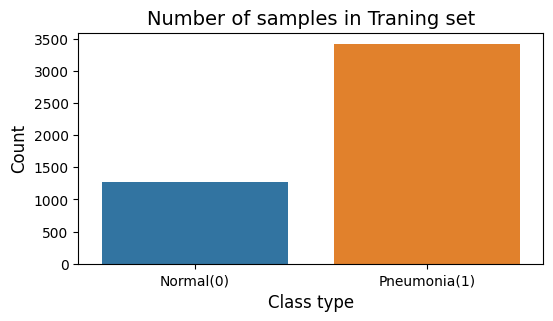

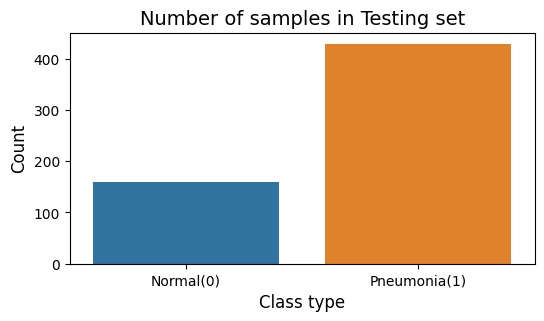

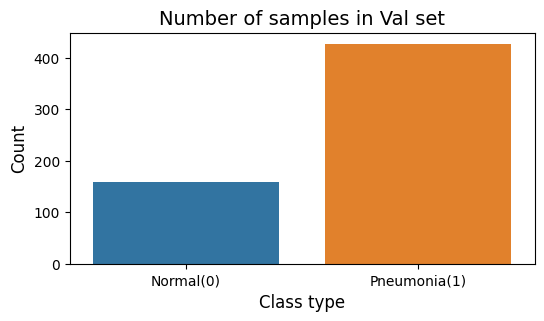

In [11]:
# show the counters for each set
import seaborn as sns

# traning set
plt.figure(figsize=(6,3))
sns.barplot(x=classes, y= [count_train_normal, count_train_pneumonia])
plt.title('Number of samples in Traning set', fontsize=14)
plt.xlabel('Class type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(classes)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

# test set
plt.figure(figsize=(6,3))
sns.barplot(x=classes, y= [count_test_normal, count_test_pneumonia])
plt.title('Number of samples in Testing set', fontsize=14)
plt.xlabel('Class type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(classes)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

# val set
plt.figure(figsize=(6,3))
sns.barplot(x=classes, y= [count_val_normal, count_val_pneumonia])
plt.title('Number of samples in Val set', fontsize=14)
plt.xlabel('Class type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(classes)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

## 2. Data Preprocesing

Spit the dataset into train, val and test.

In [ ]:
# split the dataset

# I oready split the dataset using this code

# Step1: combine all dataset into tow subfolders -> Normal and Pneumonia
# Step2: each subfoders split them into train/val/test splits and save them into folders
# input_dir = 'all_chest_xray/'
# output_dir = 'afterSplit_chest_xray/'

# splitfolders.ratio(input_dir, output=output_dir,
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

# Step3: download dataset
# data_dir = 'afterSplit_chest_xray/'
# train_dir = os.path.join(data_dir, 'train/')
# test_dir = os.path.join(data_dir, 'test/')
# val_dir = os.path.join(data_dir, 'val/')

Since currently our dataset is just a list of filenames.
We want to map each filename to the corresponding (image, label) pair.

During loading the data, we perform the basic preprocessing in each image, which are:
- Specify the channel.
- Resize the hieght and weidth.
- Convert pixel values to float.
- Normalize the pixel values.

In [12]:
# download the dataset as (image, label) pairs

# list of class names
labels = ['PNEUMONIA', 'NORMAL']

# hyperparameter > the size of image
img_size = 224
# hyperparameter > the channel of image
channel = cv2.IMREAD_COLOR

# function take the directory and return the data in pairs (image, label)
def get_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):

            if img[-4:] == 'jpeg':
                try:
                    img_arr = cv2.imread(os.path.join(path, img), channel)

                    # ---- basic preprocessing ---- #
                    # 1. reshaping images to preferred size
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    # 2. change to float datatype
                    img = resized_arr.astype('float32') 
                    # 3. normalize the pixels value to lie between 0 to 1
                    img = img / 255.0 

                    data.append([img, class_num])

                except Exception as e:
                    print(e)

    return np.array(data)

train_data = get_data(train_dir)
test_data = get_data(test_dir)
valid_data = get_data(val_dir)

In [13]:
# further split each pair to be x for data and y for label
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in valid_data:
    x_val.append(feature)
    y_val.append(label)

In [14]:
# convert the lists of x and y into numpy arrays
# so that to make it suitable as input for tensorflow methods (fit, evaluate, predict)
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train).reshape(len(y_train), 1)
y_val = np.array(y_val).reshape(len(y_val),1)
y_test = np.array(y_test).reshape(len(y_test), 1)

In [15]:
# print their shapes
print('Training set images shape: ', x_train.shape)
print('Training set labels shape: ', y_train.shape)
print('-----------------------------')
print('Testing set images shape: ', x_test.shape)
print('Testing set labels shape: ', y_test.shape)
print('-----------------------------')
print('Validation set images shape: ', x_val.shape)
print('Validation set labels shape: ', y_val.shape)

Training set images shape:  (4688, 224, 224, 3)
Training set labels shape:  (4688, 1)
-----------------------------
Testing set images shape:  (588, 224, 224, 3)
Testing set labels shape:  (588, 1)
-----------------------------
Validation set images shape:  (585, 224, 224, 3)
Validation set labels shape:  (585, 1)


In [ ]:
# Data augmentation in order to
# - increase the dataset 
# - reduce overfitting to give the model more generalizability
# - contribute to solve the unbalance problem

# datagen = ImageDataGenerator(
#         zoom_range = 0.2, # Randomly zoom image 
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         vertical_flip=False)  # randomly flip images

# apply these series of augmentation on train data
# datagen.fit(x_train)

## 3. Data Visualization

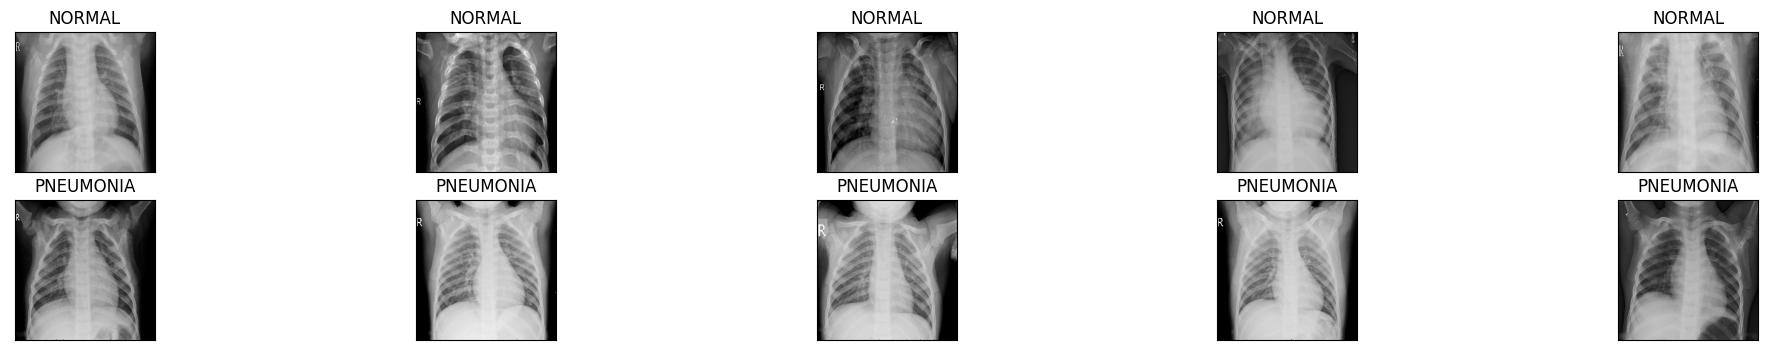

In [16]:
# plot ten images, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    if idx < 5:
      plt.imshow(x_train[idx], cmap='gray')
      plt.title(classes[y_train[idx].item()])
    else:
      plt.imshow(x_train[-idx], cmap='gray')
      plt.title(classes[y_train[-idx].item()])

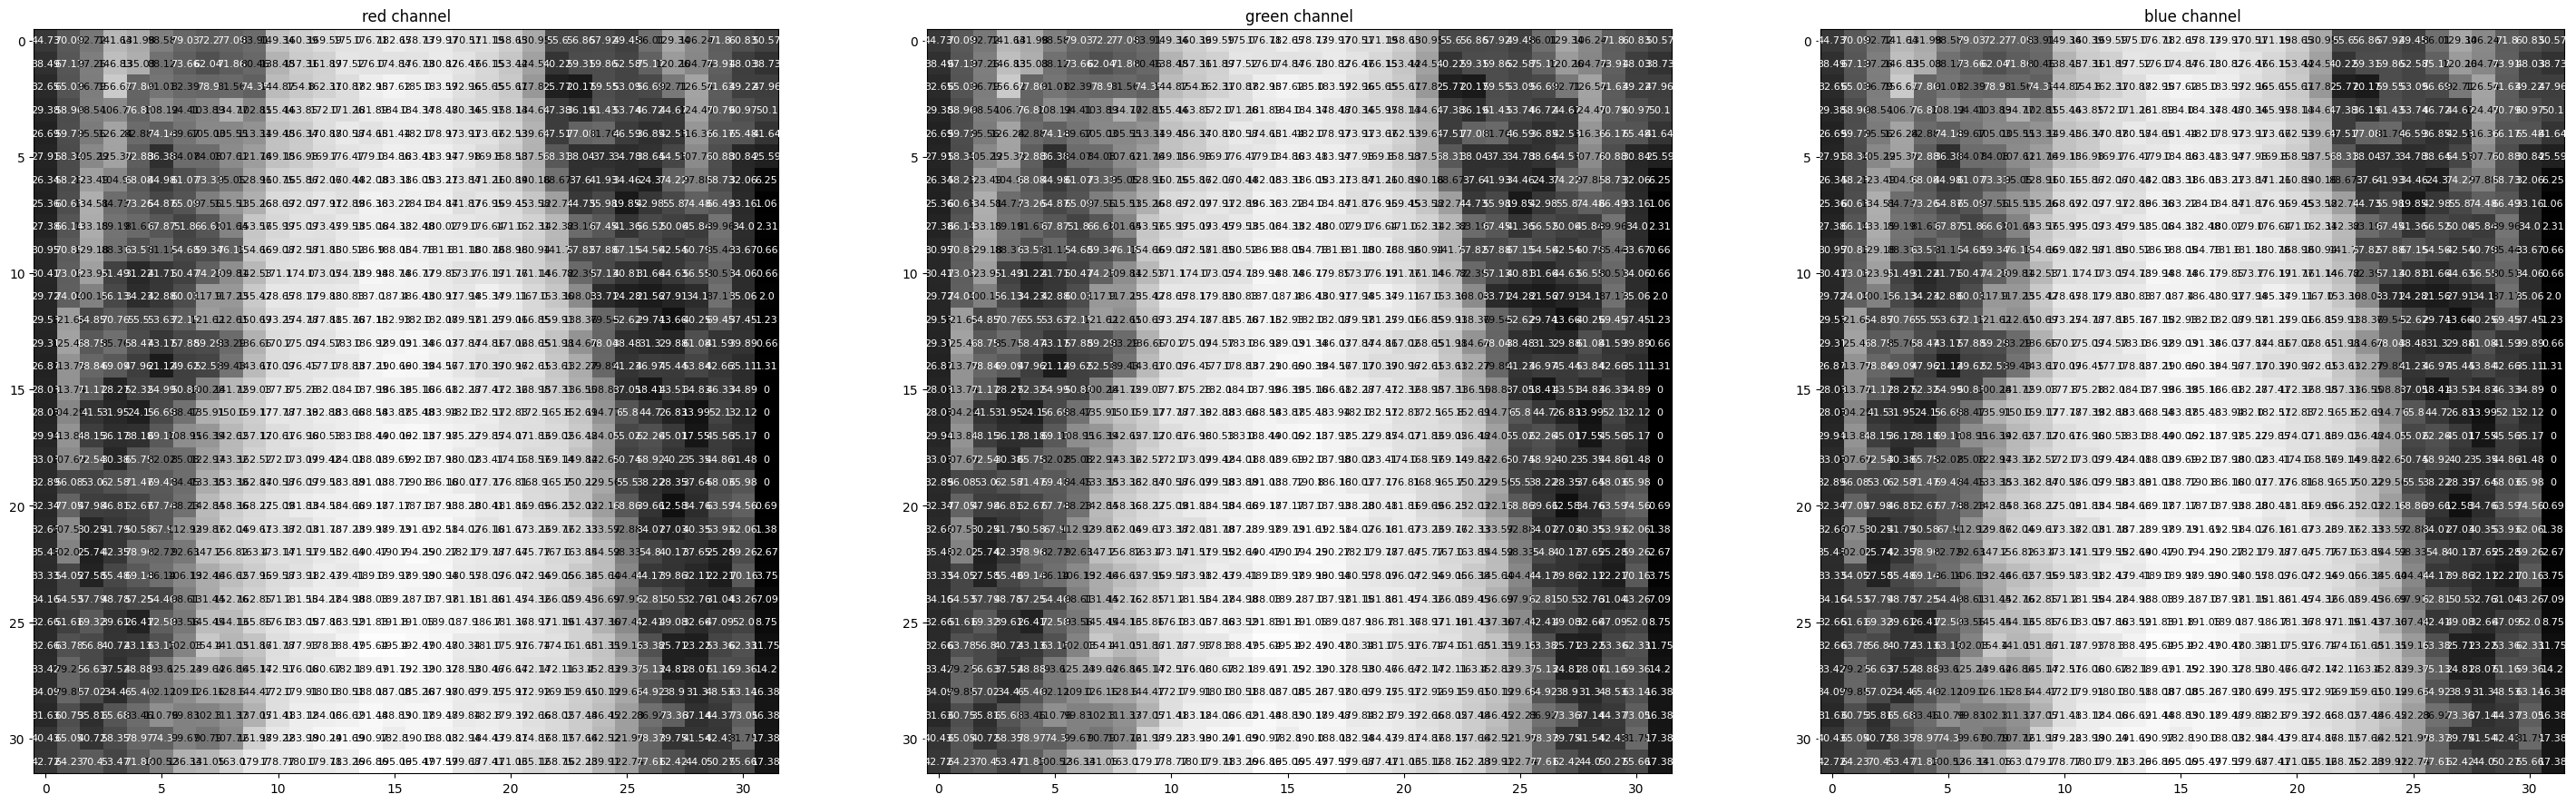

In [17]:
# view an Image in More Detail
# print the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images

image_path = train[1286][0] 
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, [32,32])
img = img.numpy().transpose(2, 0, 1)


rgb_img = np.squeeze(img)
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

# Model Development

In [18]:
# Model architecutre
def createModel1():
    # create the model using sequential method, where the order of layers will be as added
    model = Sequential()

    # first conv bolck
    # input 224x224x1, output 112x112x16
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second conv block
    # input 112x112x16, output 56x56x32
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # third conv block
    # input 56x56x32, output 28x28x64
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # forth conv block
    # input 28x28x64, output 14x14x128
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatt the last conv block ito 1D vector
    # input 14x14x128, output 25088
    model.add(Flatten())

    # first FC layer
    # input 25088, output 512
    model.add(Dense(512))
    model.add(Activation("relu"))

    # second FC layer
    # input 512, output 128
    model.add(Dense(128))
    model.add(Activation("relu"))

    # third FC layer
    # input 128, output 64
    model.add(Dense(64))
    model.add(Activation("relu"))

    # forth FC layer
    # input 64, output 1
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    return model

In [21]:
# initiate the model
model1 = createModel1()
# show the model info
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     1

In [19]:
# correct the imbalance by re-Weighting the minority class
weight_for_0 = (1 / count_train_normal)*(count_train_normal+count_train_pneumonia)/2.0 
weight_for_1 = (1 / count_train_pneumonia)*(count_train_normal+count_train_pneumonia)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.68


In [22]:
# prepare the optimizer, loss function and metrics to monitor during traning 
optimizer= tf.keras.optimizers.SGD()
loss = 'binary_crossentropy'
metrics = ['accuracy',
tf.keras.metrics.Precision(name='precision'), 
tf.keras.metrics.Recall(name='recall'),
tf.keras.metrics.TruePositives(name='TP'),
tf.keras.metrics.TrueNegatives(name='TN'),
tf.keras.metrics.FalsePositives(name='FP'),
tf.keras.metrics.FalseNegatives(name='FN')]

model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

In [23]:
# prepare the hyperparameters for traning

batch_size = 32
epochs = 20

# call back elements

# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)

# train the model
history = model1.fit(
    # datagen.flow(x_train, y_train, batch_size = 32),
    x_train, y_train, batch_size=batch_size, 
    epochs=epochs, 
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, save_best],
    shuffle=True,
    class_weight=class_weight)


Epoch 1/20
147/147 [==============================] - 71s 104ms/step - loss: 0.2612 - accuracy: 0.8884 - precision: 0.9114 - recall: 0.6501 - TP: 823.0000 - TN: 3342.0000 - FP: 80.0000 - FN: 443.0000 - val_loss: 0.8796 - val_accuracy: 0.7299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 427.0000 - val_FP: 0.0000e+00 - val_FN: 158.0000
Epoch 2/20
147/147 [==============================] - 13s 86ms/step - loss: 0.1366 - accuracy: 0.9450 - precision: 0.9599 - recall: 0.8310 - TP: 1052.0000 - TN: 3378.0000 - FP: 44.0000 - FN: 214.0000 - val_loss: 1.0434 - val_accuracy: 0.7299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 427.0000 - val_FP: 0.0000e+00 - val_FN: 158.0000
Epoch 3/20
147/147 [==============================] - 14s 95ms/step - loss: 0.1080 - accuracy: 0.9548 - precision: 0.9680 - recall: 0.8610 - TP: 1090.0000 - TN: 3386.0000 - FP: 36.0000 - FN: 176.0000 - val_loss: 0.3954 - v

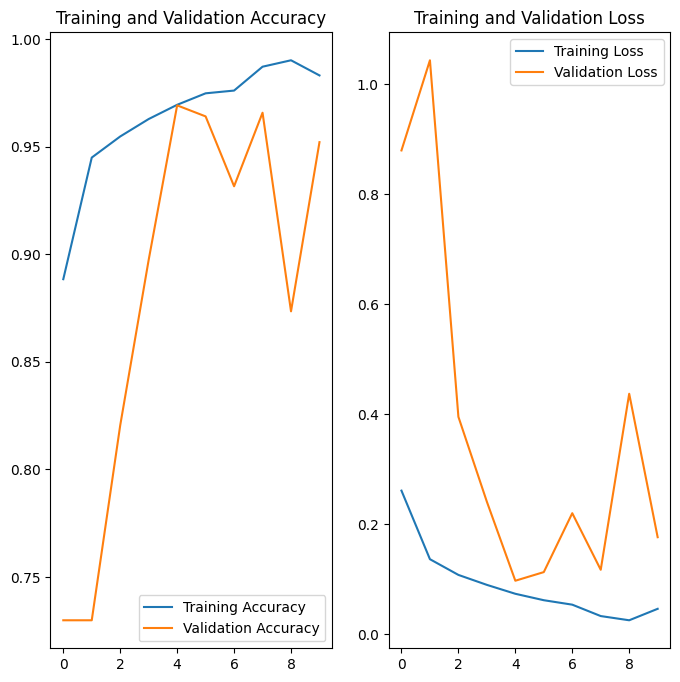

In [24]:
# show the accuracies and losses of traning and validation
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Hyper-parameters tuning with k-folds

K-Folds cross-validator as evaluation technqiues using KerasClassifier and cross_val_score.

In [43]:
# combine the train and validation into one set
X_train = np.concatenate((x_train, x_val))
print(X_train.shape)

Y_train = np.concatenate((y_train, y_val))
print(Y_train.shape)

(5273, 224, 224, 3)
(5273, 1)


In [44]:
# define the model arichitecture and its configuration
def create_model():
    # create the model using sequential method, where the order of layers will be as added
    model = Sequential()

    # first conv bolck
    # input 224x224x1, output 112x112x16
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second conv block
    # input 112x112x16, output 56x56x32
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # third conv block
    # input 56x56x32, output 28x28x64
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # forth conv block
    # input 28x28x64, output 14x14x128
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatt the last conv block ito 1D vector
    # input 14x14x128, output 25088
    model.add(Flatten())

    # first FC layer
    # input 25088, output 512
    model.add(Dense(512))
    model.add(Activation("relu"))

    # second FC layer
    # input 512, output 128
    model.add(Dense(128))
    model.add(Activation("relu"))

    # third FC layer
    # input 128, output 64
    model.add(Dense(64))
    model.add(Activation("relu"))

    # forth FC layer
    # input 64, output 1
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    optimizer= tf.keras.optimizers.SGD()
    loss = 'binary_crossentropy'
    metrics = ['accuracy',
    tf.keras.metrics.Precision(name='precision'), 
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.TruePositives(name='TP'),
    tf.keras.metrics.TrueNegatives(name='TN'),
    tf.keras.metrics.FalsePositives(name='FP'),
    tf.keras.metrics.FalseNegatives(name='FN')]

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    return model

In [45]:
# perform k fold CV as evaluation technqiue, wihout hyperparameters tunning


# k fold cv object
kf = KFold(n_splits=3, shuffle= True, random_state=2)

# hyperparameters
batch_size = 32
epochs = 10


# wrapper to hold keras obj 
model2 = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size,
                        verbose=1,
                        shuffle=True)


# fit the model with k fold object
results = cross_val_score(model2, X_train, Y_train, cv=kf) 

Epoch 1/10
110/110 [==============================] - 11s 86ms/step - loss: 0.2887 - accuracy: 0.8848 - precision: 0.7960 - recall: 0.7786 - TP: 749.0000 - TN: 2361.0000 - FP: 192.0000 - FN: 213.0000
Epoch 2/10
110/110 [==============================] - 9s 81ms/step - loss: 0.1457 - accuracy: 0.9471 - precision: 0.9050 - recall: 0.9012 - TP: 867.0000 - TN: 2462.0000 - FP: 91.0000 - FN: 95.0000
Epoch 3/10
110/110 [==============================] - 9s 82ms/step - loss: 0.1066 - accuracy: 0.9602 - precision: 0.9363 - recall: 0.9168 - TP: 882.0000 - TN: 2493.0000 - FP: 60.0000 - FN: 80.0000

In [46]:
print("Scores each folds: ", results)
print("K-fold Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Scores each folds:  [0.94823664 0.9590444  0.9618668 ]
K-fold Results: 95.64% (0.59%)


K-Folds cross-validator as hyperparameters tunning and evaluation for different hyperparameters values using  GridSearch and KerasClassifier.

In [48]:
# model arichitecture and configuration
def create_model(optimizer='adam'):
    # create the model using sequential method, where the order of layers will be as added
    model = Sequential()

    # first conv bolck
    # input 224x224x1, output 112x112x16
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second conv block
    # input 112x112x16, output 56x56x32
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # third conv block
    # input 56x56x32, output 28x28x64
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # forth conv block
    # input 28x28x64, output 14x14x128
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatt the last conv block ito 1D vector
    # input 14x14x128, output 25088
    model.add(Flatten())

    # first FC layer
    # input 25088, output 512
    model.add(Dense(512))
    model.add(Activation("relu"))

    # second FC layer
    # input 512, output 128
    model.add(Dense(128))
    model.add(Activation("relu"))

    # third FC layer
    # input 128, output 64
    model.add(Dense(64))
    model.add(Activation("relu"))

    # forth FC layer
    # input 64, output 1
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    loss = 'binary_crossentropy'
    metrics = ['accuracy',
    tf.keras.metrics.Precision(name='precision'), 
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.TruePositives(name='TP'),
    tf.keras.metrics.TrueNegatives(name='TN'),
    tf.keras.metrics.FalsePositives(name='FP'),
    tf.keras.metrics.FalseNegatives(name='FN')]

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    return model

In [49]:
# using k fold as hyperparamer tunning 

# define cross-validation method
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# different variation of k fold cross validator
# skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)
kf = KFold(n_splits=3, shuffle= True, random_state= 17)

# define Model wihtout specifing hyperparamers value
model3 = KerasClassifier(build_fn=create_model,
                        verbose=1,
                        shuffle=True,
                        class_weight=class_weight)

# define Hyper-parameter and its list values
optimizer =  ['SGD', 'adam'] 
batch_size = [16, 32]
epochs = [5, 10]

param_grid = dict(optimizer=optimizer,batch_size=batch_size, epochs=epochs)

# define the evaluate the performance of the cross-validated model on the test set
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
scoring = make_scorer(accuracy_score)

# define GridSearchCV and fit it in the model
grid = GridSearchCV(estimator=model3, param_grid=param_grid, refit = True, scoring = scoring, cv=kf)
grid_model = grid.fit(X_train, Y_train)

Epoch 1/10
220/220 [==============================] - 14s 53ms/step - loss: 0.2778 - accuracy: 0.8748 - precision: 0.8823 - recall: 0.6284 - TP: 607.0000 - TN: 2468.0000 - FP: 81.0000 - FN: 359.0000
Epoch 2/10
220/220 [==============================] - 12s 53ms/step - loss: 0.1458 - accuracy: 0.9400 - precision: 0.9489 - recall: 0.8261 - TP: 798.0000 - TN: 2506.0000 - FP: 43.0000 - FN: 168.0000
Epoch 3/10
220/220 [==============================] - 11s 48ms/step - loss: 0.1107 - accuracy: 0.9550 - precision: 0.9709 - recall: 0.8623 - TP: 833.0000 - TN: 2524.0000 - FP: 25.0000 - FN: 133.0000

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# the best Model
print("Best: %f using %s" % (grid_model.best_score_, grid_model.best_params_))

# print all experiment results
import pandas as pd
results = pd.DataFrame(grid_model.cv_results_)
results

In [ ]:
# print the best value of precesion score
print('Best Score: %s' % grid_model.best_score_)

# print best parameter after tuning
print("\nBest parameters set:")
print(grid_model.best_params_)
 
# print how our model looks after hyper-parameter tuning
print("\nBest modelt:")
print(grid.best_estimator_) # == grid_model

# # get the best estimtor model
# best_model = grid.best_estimator_
     

In [ ]:
# score on the refit data
scores = grid_model.score(x_test, y_test)

# predict on the refit data
predictions = grid_model.predict(x_test)

# Model Evaluation

In [25]:
# Evaluation on test dataset

loss, acc, prec, rec, tp, tn, fp, fn = model1.evaluate(x_test, y_test, batch_size=16)

print("Loss on test set: ", loss)
print("Accuracy on test set: ", acc)
print("Precision on test set: ", prec)
print("Recall on test set: ", rec)
print("TP on test set: ", tp)
print("TN on test set: ", tn)
print("FP on test set: ", fp)
print("FN on test set: ", fn)
# {:.2f}".format(accuracy))

37/37 [==============================] - 1s 24ms/step - loss: 0.1174 - accuracy: 0.9592 - precision: 0.9245 - recall: 0.9245 - TP: 147.0000 - TN: 417.0000 - FP: 12.0000 - FN: 12.0000
Loss on test set:  0.11742593348026276
Accuracy on test set:  0.9591836929321289
Precision on test set:  0.9245283007621765
Recall on test set:  0.9245283007621765
TP on test set:  147.0
TN on test set:  417.0
FP on test set:  12.0
FN on test set:  12.0


In [26]:
# Get predictions
def probability_to_class(preds):
    preds_class = []
    for p in preds:
        if p < 0.5:
            preds_class.append(0)
        else:
            preds_class.append(1)
    return np.array(preds_class).reshape(preds.shape[0],1)


preds = model1.predict(x_test, batch_size=16)
preds = probability_to_class(preds)

37/37 [==============================] - 1s 18ms/step


<Figure size 640x480 with 0 Axes>

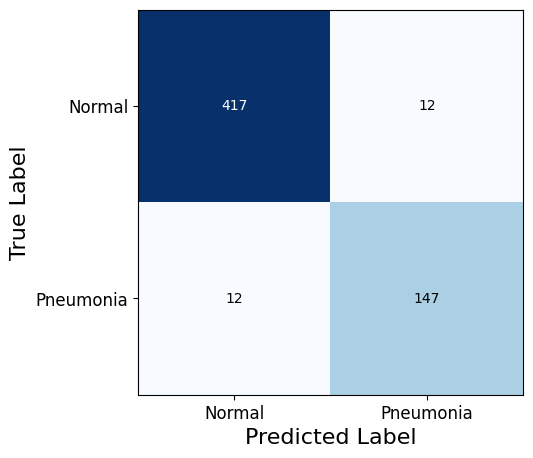

In [29]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(5,5),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)
plt.show()

In [30]:
# print the precision, recall and f1-score for each class
print(classification_report(y_test, preds, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.97      0.97       429
   Normal (Class 1)       0.92      0.92      0.92       159

           accuracy                           0.96       588
          macro avg       0.95      0.95      0.95       588
       weighted avg       0.96      0.96      0.96       588



# Saving the model

In [31]:
saved_keras_model_filepath = './model_saved'

model1.save(saved_keras_model_filepath)

In [32]:
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     1

# Inference/Prediction 

Model prediction on test data.

19/19 [==============================] - 1s 32ms/step
0.35994476079940796
0.010969411581754684
0.15181656181812286


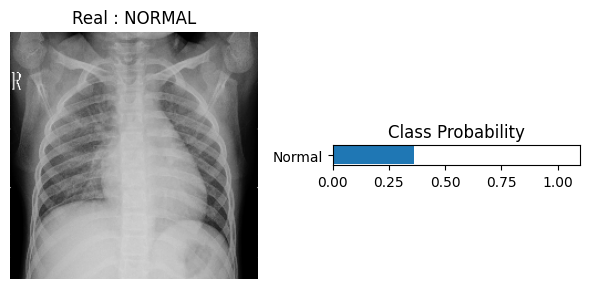

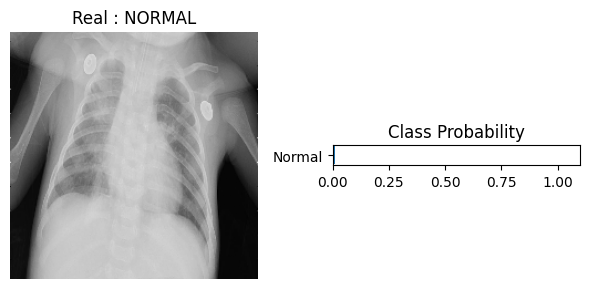

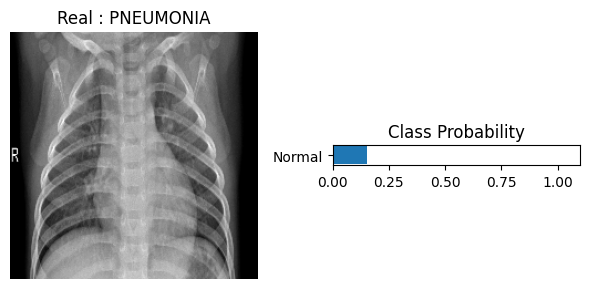

In [41]:
# show the first three images on test set along with their actual and predicted labels
# # select 5 normal and 5 pneumonia images indices
# idxs = np.array(np.append(np.arange(start=0, stop=5, step=1), 
#                              np.arange(start=500, stop=505, step=1))) 
ps = reloaded_keras_model.predict(x_test)

for idx in list([4, 114, -86]):
    if ps[idx].item() < 5:
        class_n = 'Normal'
    else:
        class_n = 'Pneumonia'
    print(ps[idx].item())
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(x_test[idx].squeeze(), cmap = plt.cm.binary)
    ax1.set_title('Real : {}'.format(classes[y_test[idx].item()]))
    ax1.axis('off')

    ax2.barh(np.arange(1), ps[idx].item())
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(1))
    ax2.set_yticklabels([class_n])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Model prediction on new data (from the internet)

In [39]:
# Create the process_image function
def process_image(img):
    img_arr = cv2.imread(img)
    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    img = resized_arr.astype('float32') # Change to float datatype
    img = img / 255.0 # Normalize the data to lie between 0 to 1
    
    image_numpy = np.array(img)
    return image_numpy

# Create the predict function

def predict(image_path, model):
    
    processed_image = process_image(image_path)
    processed_image_expand = np.expand_dims(processed_image, axis=0) # add dim of Examples
    
    ps = model.predict(processed_image_expand) #return numpy array 1X1

    
    if ps.item() < 0.5:
        class_n = 'Normal'
    else:
        class_n = 'Pneumonia'
    return ps.item(), class_n

1/1 [==============================] - 0s 237ms/step


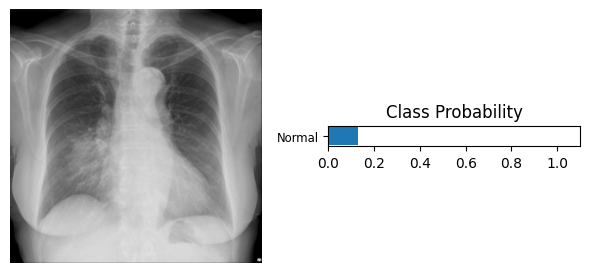

In [40]:
# Plot the input image along with the class
image_path = 'New images/img1.jpeg'
im = cv2.imread(image_path)
test_image = np.array(im)

probs, class_n = predict(image_path, reloaded_keras_model)

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_image)
ax1.axis('off')

ax2.barh(np.arange(1), probs)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(1))


ax2.set_yticklabels([class_n], size='small');


ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

# References
- (1) https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy#Analysis-after-Model-Training